Segmentation
=======

In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

from skimage.transform import resize

from mean_shift.mean_shift_utils import *
from mean_shift.mean_shift import *

Original image
----------------

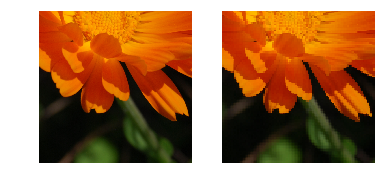

In [39]:
orig_img = plt.imread('data/DSC_0055.JPG')[1000:2000, 1600:2600]
plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.axis('off')

resized_img = 255 * resize(orig_img, (orig_img.shape[0] / 10, orig_img.shape[1] / 10))
img = resized_img.astype(np.uint8)

plt.subplot(1, 2, 2)
plt.imshow(img)

plt.axis('off')

plt.imsave('./orig.png', img)

Mean Shift Filter
-----------------------------------

The kernel for segmentation
$$K_{h_s, h_r}(\mathbf{x}) = \frac{C}{{h^2_s} {h^p_r}}k(\|\frac{\mathbf{x}^s}{h_s}\|^2)k(\|\frac{\mathbf{x}^r}{h_r}\|^2)$$

(-0.5, 99.5, 99.5, -0.5)

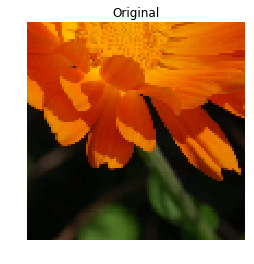

In [38]:
vecs = convert_img_vec(img)

## Demo
plt.imshow(vec2img(vecs, img.shape[:2]))
plt.title('Original')
plt.axis('off')

# plt.figure()
# plt.title('(hs=8, hr=8)')
# plt.imshow(results[(8, 8)])
# plt.axis('off')

In [5]:
bandwidths_list = [(8, 8), (8, 16), (16, 4), (16, 8), (16, 16)]
results = {}

for bandwidths in bandwidths_list:
    ms = mean_shift(kernel=segmentation_kernel)
    vec_c = ms.cluster(vecs, kernel_bandwidth=bandwidths)
    shift_im = vec2img(vec_c, img.shape[:2])
    results[bandwidths] = shift_im

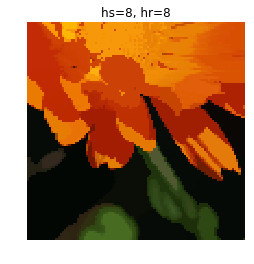

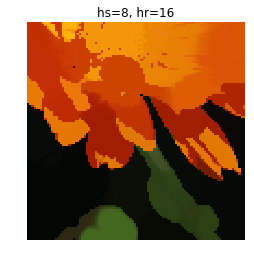

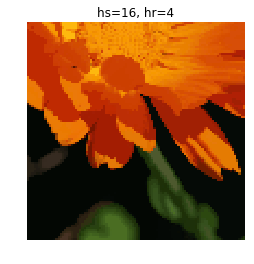

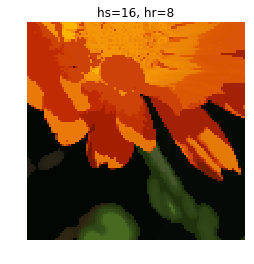

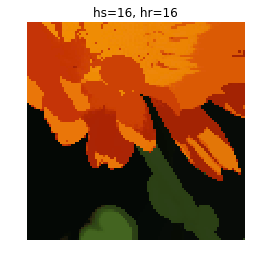

In [36]:
for key in bandwidths_list:
    value = results[key]
    hs, hr = key
    plt.figure()
    plt.axis('off')
    plt.title('hs={}, hr={}'.format(hs, hr))
    plt.imshow(value)
    plt.imsave('./{}_{}.png'.format(hs, hr), value)

```python
for bandwidths in [(32, 4), (32, 8), (32, 16)]:
    ms = mean_shift(kernel=segmentation_kernel)
    vec_c = ms.cluster(vecs, kernel_bandwidth=bandwidths)
    shift_im = vec2img(vec_c, img.shape[:2])
    results[bandwidths] = shift_im
```

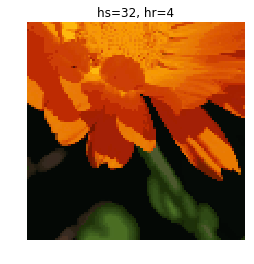

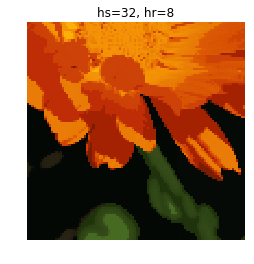

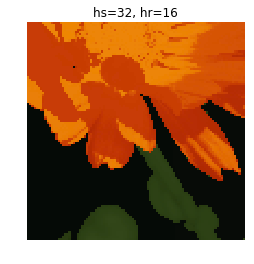

In [37]:
for key in [(32, 4), (32, 8), (32, 16)]:
    value = results[key]
    hs, hr = key
    plt.figure()
    plt.axis('off')
    plt.title('hs={}, hr={}'.format(hs, hr))
    plt.imshow(value)
    plt.imsave('./{}_{}.png'.format(hs, hr), value)

Segmentation based on Mean Shift
-------------------------------------

In [18]:
import sys
import numpy as np
import mean_shift.mean_shift_utils as ms_utils

GROUP_DISTANCE_TOLERANCE = .1


class PointGrouper(object):
    def group_points(self, points):
        group_assignment = []
        groups = []
        group_index = 0
        for point in points:
            nearest_group_index = self._determine_nearest_group(point, groups)
            if nearest_group_index is None:
                # create new group
                groups.append([point])
                group_assignment.append(group_index)
                group_index += 1
            else:
                group_assignment.append(nearest_group_index)
                groups[nearest_group_index].append(point)
        return np.array(group_assignment)

    def _determine_nearest_group(self, point, groups):
        nearest_group_index = None
        index = 0
        for group in groups:
            distance_to_group = self._distance_to_group(point, group)
            if distance_to_group < GROUP_DISTANCE_TOLERANCE:
                nearest_group_index = index
            index += 1
        return nearest_group_index

    def _distance_to_group(self, point, group):
        min_distance = sys.float_info.max
        for pt in group:
            dist = ms_utils.euclid_distance(point, pt)
            if dist < min_distance:
                min_distance = dist
        return min_distance


clf = PointGrouper()
groups = clf.group_points(vec_c)

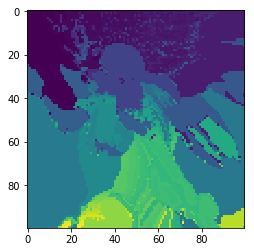

In [20]:
plt.imshow(groups.reshape(100, 100))

Segmentation based on Normalized Cut
----------------------------------------

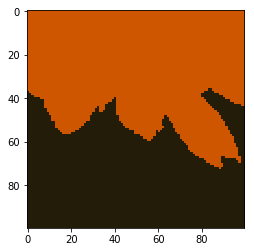

In [27]:
from skimage.future import graph
from skimage import segmentation, color

labels1 = segmentation.slic(img, compactness=30, n_segments=3)
g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out = color.label2rgb(labels2, img, kind='avg')
plt.imshow(out)